In [1]:
from __future__ import division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
import math, random
import matplotlib.pyplot as plt
%matplotlib inline

def reset_graph(seed = 42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [2]:
reset_graph()
np.random.seed(42)
n_hidden1 = 100
n_hidden2 = 2
n_inputs = 1000
n_outputs = 1
train_split = .8
batch_size = 10
n_epochs = 5001

In [3]:
def duffing_drift(x):
    alpha = -1.0
    beta = 1.0
    delta = 0.3
    gamma = 0.2
    omega = 1.0
    out = np.zeros(x.shape)

    # f_1(x_1,x_2,x_3) = x_2
    out[0] = x[1]

    # f_2(x_1,x_2,x_3) = -delta*x_2 - alpha*x_1 - beta*x_1^3 + gamma*cos(omega*x_3)
    out[1] = -delta*x[1] - alpha*x[0] - beta*np.power(x[0],3) + gamma*np.cos(omega*x[2])

    # f_3(x_1,x_2,x_3) = 1
    out[2] = 1.0

    return out

In [4]:
# true diffusion matrix
def trueg():
    out = np.zeros((3,3))
    out[0,0] = 0.4
    out[0,1] = 0.0 # 0.125
    out[1,0] = 0.0 # 0.125
    out[1,1] = 0.25
    out[2,2] = 0.0
    return out

In [5]:
def function_to_learn(x):
    return duffing_drift(x) # + trueg()

In [6]:
# euler-maruyama simulator
# ft: final time
# ns: number of steps, starting at t=0
# ic: initial condition, must be a 3x1 matrix to broadcast to 3xnt
# nt: number of trajectories desired
def emsim(ft, ns, ic, nt):
    h = ft/ns
    h12 = np.sqrt(h)
    y = np.zeros((ns+1, 3))
    y[0] = ic
    for i in range(ns):
        y[i+1] = y[i] + duffing_drift(y[i])*h
    return y

In [7]:
# multiple time series, one realization per time series
ic = np.tile(np.array([[1.0, 0.0, 0.0]]), 1)
ft = 20
ns = ft*int(1e2)
nt = 1
all_x = np.float32(np.random.uniform(0, ft, (ns+1, 3)))
all_y = emsim(ft, ns, ic, nt)

In [8]:
all_x = np.float32(np.random.uniform(-1, 1, (3, n_inputs))).T
np.random.shuffle(all_x)
train_size = int(n_inputs * train_split)
trainx = all_x[:train_size, :]
validx = all_x[train_size:, :]
trainy = function_to_learn(trainx)
validy = function_to_learn(validx)

In [9]:
all_x

array([[-0.26794347,  0.16045706,  0.72246444],
       [-0.651003  ,  0.08775584,  0.1808522 ],
       [ 0.0061452 ,  0.67841589,  0.83419698],
       ..., 
       [-0.71112704,  0.65928763, -0.22375709],
       [-0.84894586,  0.86166573,  0.50733227],
       [ 0.99892133,  0.75892538,  0.30988222]], dtype=float32)

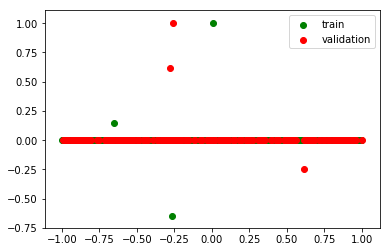

In [10]:
plt.figure(1) 
plt.scatter(trainx[:, 0], trainy[:, 0], c = 'green', label = 'train') 
plt.scatter(validx[:, 0], validy[:, 0], c = 'red', label = 'validation') 
plt.legend()

In [11]:
X = tf.placeholder(tf.float32, shape = (None, 3), name = "X")
y = tf.placeholder(tf.float32, shape = (None, 3), name = "y")

In [12]:
with tf.name_scope("function_approximator"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu, name = "hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu, name = "hidden2")
#     hidden3 = tf.layers.dense(hidden2, n_hidden3, activation = tf.nn.relu, name = "hidden3")
    logits = tf.layers.dense(hidden2, n_outputs, name = "outputs")

In [13]:
# with tf.name_scope("function_approximator"):
#     hidden1_1 = tf.layers.dense(X, n_hidden1_1, activation = tf.nn.relu, name = "hidden1_1")
#     hidden1_2 = tf.layers.dense(X, n_hidden1_2, activation = tf.nn.relu, anem = "hidden1_2")
#     hidden2_1 = tf.layers.dense(hidden1_1, n_hidden2_1, activation = tf.nn.relu, name = "hidden2_1")
#     hidden2_2 = tf.layers.dense(hidden1_2, n_hidden2_2, activation = tf.nn.relu, name = "hidden2_2")
#     logits = tf.layers.dense(hidden1, n_outputs, name = "outputs")

In [14]:
with tf.name_scope("loss"):
    loss = tf.nn.l2_loss(logits - y)

In [15]:
learning_rate = 0.1

with tf.name_scope("train"):
#     optimizer = tf.train.FtrlOptimizer(learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [17]:
with tf.name_scope("eval"):
    mse = tf.nn.l2_loss(logits - validy)

In [18]:
with tf.Session() as sess:
    init.run()
    errors = []
    for epoch in range(n_epochs):
        for start, end in zip(range(0, len(trainx), batch_size), range(batch_size, len(trainx), batch_size)):
            X_batch = trainx[start:end]
            y_batch = trainy[start:end]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        mse_test = sess.run(mse, feed_dict = {X: validx})
        errors.append(mse_test)
        if epoch % 100 == 0:
            print("Epoch:", epoch, "Validation accuracy:", mse_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

Epoch: 0 Validation accuracy: 2.19369
Epoch: 100 Validation accuracy: 2.17652
Epoch: 200 Validation accuracy: 2.17652
Epoch: 300 Validation accuracy: 2.17652
Epoch: 400 Validation accuracy: 2.17652
Epoch: 500 Validation accuracy: 2.17652
Epoch: 600 Validation accuracy: 2.17652
Epoch: 700 Validation accuracy: 2.17652
Epoch: 800 Validation accuracy: 2.17652
Epoch: 900 Validation accuracy: 2.17652
Epoch: 1000 Validation accuracy: 2.17652
Epoch: 1100 Validation accuracy: 2.17652
Epoch: 1200 Validation accuracy: 2.17652
Epoch: 1300 Validation accuracy: 2.17652
Epoch: 1400 Validation accuracy: 2.17652
Epoch: 1500 Validation accuracy: 2.17652
Epoch: 1600 Validation accuracy: 2.17652
Epoch: 1700 Validation accuracy: 2.17652
Epoch: 1800 Validation accuracy: 2.17652
Epoch: 1900 Validation accuracy: 2.17652
Epoch: 2000 Validation accuracy: 2.17652
Epoch: 2100 Validation accuracy: 2.17652
Epoch: 2200 Validation accuracy: 2.17652
Epoch: 2300 Validation accuracy: 2.17652
Epoch: 2400 Validation accur

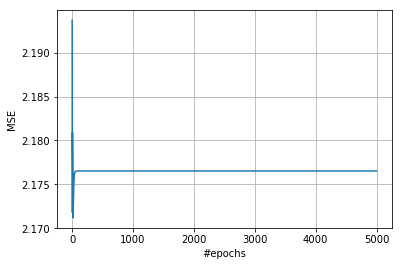

In [19]:
plt.plot(errors)
plt.xlabel('#epochs')
plt.ylabel('MSE')
plt.grid(True)

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    print(tf.trainable_variables())

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
[<tf.Variable 'hidden1/kernel:0' shape=(3, 100) dtype=float32_ref>, <tf.Variable 'hidden1/bias:0' shape=(100,) dtype=float32_ref>, <tf.Variable 'hidden2/kernel:0' shape=(100, 2) dtype=float32_ref>, <tf.Variable 'hidden2/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'outputs/kernel:0' shape=(2, 1) dtype=float32_ref>, <tf.Variable 'outputs/bias:0' shape=(1,) dtype=float32_ref>]
